In [1]:
import numpy as np
import random
n=4
k=2
M=2**k
#Generate random numbers between 0 and 15 for training data
symbols = np.random.randint(0,M,100000)
X_train = np.zeros((symbols.size, symbols.max()+1))
X_train[np.arange(symbols.size),symbols] = 1
#X_train.shape

In [2]:
#Generate random numbers between 0 and 15 for test data
symbols = np.random.randint(0,M,10000)
X_test = np.zeros((symbols.size, symbols.max()+1))
X_test[np.arange(symbols.size),symbols] = 1

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model 
from keras.layers import Input, Dense, ReLU, BatchNormalization 
inputs= X_test.shape[1]


In [4]:
class CustomLayer(keras.layers.Layer):
    def __init__(self, units=32, **kwargs):
        super(CustomLayer, self).__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

    def get_config(self):
        config = super(CustomLayer, self).get_config()
        config.update({"units": self.units})
        return config


def custom_activation(x,axis=-1):
    return x/tf.sqrt(tf.reduce_sum(x*x, axis=axis, keepdims=True)/x.shape[1])


#keras.layers.Activation(custom_activation)(encoder_layer)

In [5]:
#define the encoder 
encoder_input= Input(shape=(inputs,))
encoder_layer=Dense(inputs, activation="relu")(encoder_input)
encoder_layer=Dense(n, activation="linear")(encoder_layer)
encoder_output= BatchNormalization()(encoder_layer) 

#encoder_output= keras.layers.LayerNormalization()(encoder_layer) 
#encoder_output=2*tf.keras.activations.sigmoid(encoder_output)

In [6]:
R=4/7;
Eb_No_training=7; ## dB
Eb_No_training_ratio=10**(Eb_No_training/10);
stddev=(2*R*Eb_No_training_ratio)**(-0.5);
channel_output=tf.keras.layers.GaussianNoise(stddev)(encoder_output)

In [7]:
# define the decoder 
decoder= Dense(inputs, activation="relu")(channel_output) 
decoder_output = Dense(inputs, activation="softmax")(decoder)

In [8]:
# define the autoencoder

autoencoder=Model(inputs=encoder_input, outputs=decoder_output)

## encoder side
encoder=Model(inputs=encoder_input, outputs=encoder_output)

#decoder side 
decoder=Model(inputs=channel_output, outputs=decoder_output)

In [9]:
autoencoder.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
history=autoencoder.fit(X_train,X_train,epochs=50, validation_data=(X_test,X_test),batch_size=128)
#autoencoder.save("functional_encoder.h5")

Epoch 1/50
782/782 [==============================] - 2s 2ms/step - loss: 0.6258 - accuracy: 0.7602 - val_loss: 0.0331 - val_accuracy: 1.0000
Epoch 2/50
782/782 [==============================] - 1s 2ms/step - loss: 0.0183 - accuracy: 1.0000 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 3/50
782/782 [==============================] - 1s 1ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 8.2485e-04 - val_accuracy: 1.0000
Epoch 4/50
782/782 [==============================] - 1s 1ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 3.3972e-04 - val_accuracy: 1.0000
Epoch 5/50
782/782 [==============================] - 1s 1ms/step - loss: 6.3672e-04 - accuracy: 1.0000 - val_loss: 1.6246e-04 - val_accuracy: 1.0000
Epoch 6/50
782/782 [==============================] - 1s 2ms/step - loss: 3.3975e-04 - accuracy: 1.0000 - val_loss: 8.3672e-05 - val_accuracy: 1.0000
Epoch 7/50
782/782 [==============================] - 1s 1ms/step - loss: 2.0277e-04 - accuracy: 1.0000 - val_loss: 4.4836e-

In [10]:
#Generate random numbers between 0 and 15 for BER calculations
test_size=1000000;
symbols = np.random.randint(0,M,test_size)
X_test = np.zeros((symbols.size, symbols.max()+1))
X_test[np.arange(symbols.size),symbols] = 1

#generating a E/N vector
R=4/7;
num_steps=26
Eb_No=np.linspace(-4,8,num_steps); ## dB

BER=np.zeros(num_steps)
for i in range(len(Eb_No)):
    if Eb_No[i]<=0:
        Eb_No_ratio=10**(Eb_No[i]/10);
        stddev=(2*R*Eb_No_ratio)**(-0.5);
        encodedsymbols=encoder.predict(X_test)
        noise = np.random.normal(0,stddev,[test_size,n])
        noisy=encodedsymbols+noise
        a=decoder.predict(noisy)
        idx = np.argmax(a, axis=-1)
        a = np.zeros( a.shape )
        a[ np.arange(a.shape[0]), idx] = 1
        recovered_symbols=np.argmax(a, axis=1)
        errors=np.count_nonzero(recovered_symbols-symbols)
        BER[i]=errors/len(symbols)
    else:
        BE=np.zeros(1)
        for jj in range(10):
            Eb_No_ratio=10**(Eb_No[i]/10);
            stddev=(2*R*Eb_No_ratio)**(-0.5);
            encodedsymbols=encoder.predict(X_test)
            noise = np.random.normal(0,stddev,[test_size,n])
            noisy=encodedsymbols+noise
            a=decoder.predict(noisy)
            idx = np.argmax(a, axis=-1)
            a = np.zeros( a.shape )
            a[ np.arange(a.shape[0]), idx] = 1
            recovered_symbols=np.argmax(a, axis=1)
            errors=np.count_nonzero(recovered_symbols-symbols)
            Erorrrrs=errors/len(symbols)
            BE+=Erorrrrs
        BER[i]=BE/10


31250/31250 [==============================] - 28s 892us/step


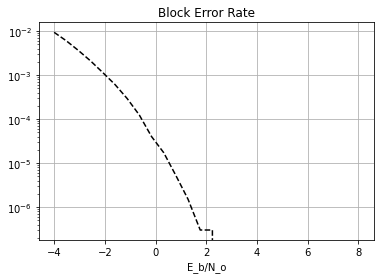

In [16]:
import matplotlib.pyplot as plt
plt.semilogy(Eb_No, BER, 'k--')
plt.title('Block Error Rate')
plt.xlabel('E_b/N_o')
plt.grid(True)
plt.show()

In [21]:
np.savez('BER_4_2.npz', BER=BER,Eb_No=Eb_No)
d = np.load('BER_4_2.npz')
print(d['BER'])
print(d['Eb_No'])

[9.341e-03 5.998e-03 3.603e-03 2.084e-03 1.135e-03 6.080e-04 2.920e-04
 1.230e-04 4.000e-05 1.720e-05 5.200e-06 1.500e-06 3.000e-07 3.000e-07
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
[-4.   -3.52 -3.04 -2.56 -2.08 -1.6  -1.12 -0.64 -0.16  0.32  0.8   1.28
  1.76  2.24  2.72  3.2   3.68  4.16  4.64  5.12  5.6   6.08  6.56  7.04
  7.52  8.  ]


In [12]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 4)                 20        
                                                                 
 dense_1 (Dense)             (None, 4)                 20        
                                                                 
 batch_normalization (BatchN  (None, 4)                16        
 ormalization)                                                   
                                                                 
 gaussian_noise (GaussianNoi  (None, 4)                0         
 se)                                                             
                                                                 
 dense_2 (Dense)             (None, 4)                 20    

In [13]:
encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 4)                 20        
                                                                 
 dense_1 (Dense)             (None, 4)                 20        
                                                                 
 batch_normalization (BatchN  (None, 4)                16        
 ormalization)                                                   
                                                                 
Total params: 56
Trainable params: 48
Non-trainable params: 8
_________________________________________________________________


In [14]:
decoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_2 (Dense)             (None, 4)                 20        
                                                                 
 dense_3 (Dense)             (None, 4)                 20        
                                                                 
Total params: 40
Trainable params: 40
Non-trainable params: 0
_________________________________________________________________


313/313 [==============================] - 1s 1ms/step


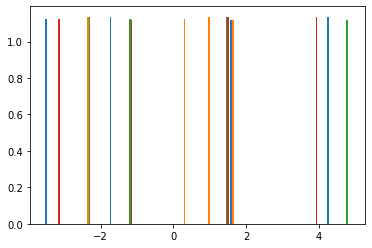

In [17]:
#Generate random numbers between 0 and 15 for test data
symbols = np.random.randint(0,M,10000)
X_test = np.zeros((symbols.size, symbols.max()+1))
X_test[np.arange(symbols.size),symbols] = 1

encodedsymbols=encoder.predict(X_test)
noise = np.random.normal(0,stddev,[10000,n])
noisy=encodedsymbols+noise
import matplotlib.pyplot as plt
plt.hist(encodedsymbols, bins='auto', density=True)
plt.show()

c:\Users\moata\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\moata\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


t-SNE done! Time elapsed: 82.96873354911804 seconds


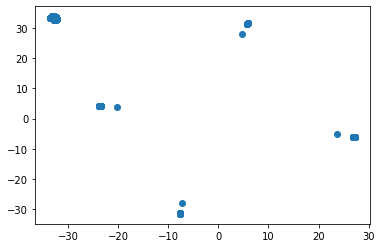

In [19]:
import matplotlib.pyplot as plt
import time
from sklearn.manifold import TSNE

#n_sne = 7000

time_start = time.time()
tsne = TSNE( random_state=0)
tsne_results = tsne.fit_transform(encodedsymbols)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

plt.scatter(tsne_results[:,0],tsne_results[:,1])

c:\Users\moata\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\moata\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


t-SNE done! Time elapsed: 85.73617148399353 seconds


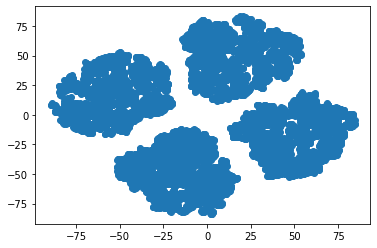

In [20]:
import matplotlib.pyplot as plt
import time
from sklearn.manifold import TSNE

#n_sne = 7000

time_start = time.time()
tsne = TSNE( random_state=0)
tsne_results = tsne.fit_transform(noisy)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

plt.scatter(tsne_results[:,0],tsne_results[:,1])

In [ ]:
#convert the probability to hot vector
a=decoded_symbols
idx = np.argmax(a, axis=-1)
a = np.zeros( a.shape )
a[ np.arange(a.shape[0]), idx] = 1

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


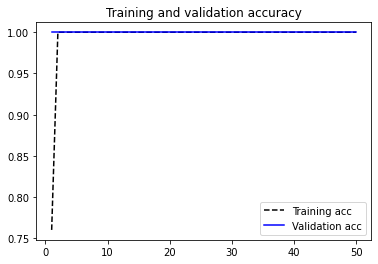

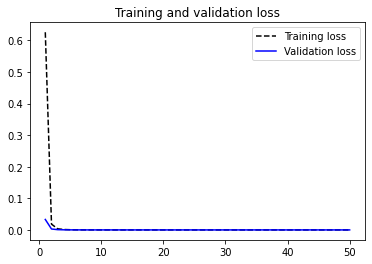

In [23]:
import matplotlib.pyplot as plt

epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'k--', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'k--', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
#Generate random numbers between 0 and 15 for BER calculations
test_size=1000000;
symbols = np.random.randint(0,M,test_size)
X_test = np.zeros((symbols.size, symbols.max()+1))
X_test[np.arange(symbols.size),symbols] = 1

#generating a E/N vector
R=4/7;
num_steps=26
Eb_No=np.linspace(-4,8,num_steps); ## dB

31250/31250 [==============================] - 34s 1ms/step


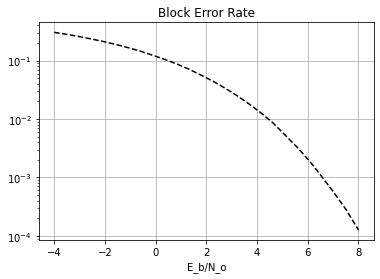

In [ ]:
BER=np.zeros(num_steps)
for i in range(len(Eb_No)):
  Eb_No_ratio=10**(Eb_No[i]/10);
  stddev=(2*R*Eb_No_ratio)**(-0.5);
  encodedsymbols=encoder.predict(X_test)
  noise = np.random.normal(0,stddev,[test_size,n])
  noisy=encodedsymbols+noise
  a=decoder.predict(noisy)
  idx = np.argmax(a, axis=-1)
  a = np.zeros( a.shape )
  a[ np.arange(a.shape[0]), idx] = 1
  recovered_symbols=np.argmax(a, axis=1)
  errors=np.count_nonzero(recovered_symbols-symbols)
  BER[i]=errors/len(symbols)


import matplotlib.pyplot as plt

plt.semilogy(Eb_No, BER, 'k--')
plt.title('Block Error Rate')
plt.xlabel('E_b/N_o')
plt.grid(True)
plt.show()


In [ ]:
d = np.load('BER_2_2_t.npz')
print(d['BER'])
print(d['Eb_No'])

In [ ]:
import matplotlib.pyplot as plt
plt.semilogy(Eb_No, d['BER'], 'k--')
plt.title('Block Error Rate')
plt.xlabel('E_b/N_o')
plt.grid(True)
plt.show()